In [45]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA

from script.helpers import get_data

In [14]:
X, holds, _ = get_data(dates=['0423'])

In [77]:
pca = PCA(n_components=1)
pca.fit(X[holds != 'idle'])
X['PCA1'] = pca.transform(X)

array([[<Axes: title={'center': 'crimp_20mm'}>,
        <Axes: title={'center': 'crimp_45mm'}>],
       [<Axes: title={'center': 'idle'}>,
        <Axes: title={'center': 'jug'}>],
       [<Axes: title={'center': 'sloper_35deg'}>, <Axes: >]], dtype=object)

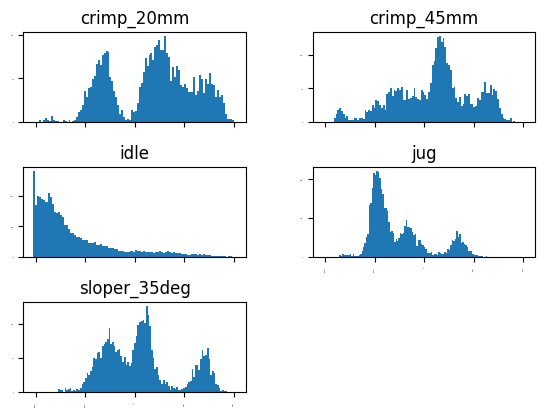

In [78]:
X.PCA1.hist(by=holds, bins=100, xlabelsize=0, ylabelsize=0, sharex=True)